In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import os

In [2]:
from ranking_funcs import filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
book_df=pd.read_csv('Amazon_Books_Data.csv')
bk_df=book_df.iloc[:,:12]
bk_df.loc[~bk_df['best_seller'].isin(['Yes', 'No']), 'best_seller'] = np.nan
bk_df['best_seller'] = bk_df['best_seller'].replace({'Yes': 1, 'No': 0}).astype(float)
bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)
bk_df['rating'] = pd.to_numeric(bk_df['rating'], errors='coerce')
bk_df['review_count'] = pd.to_numeric(bk_df['review_count'], errors='coerce')
bk_df['edition'] = pd.to_numeric(bk_df['edition'], errors='coerce')

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_23442/2943498763.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bk_df['price'] = bk_df['price'].str.replace('$', '').astype(float)


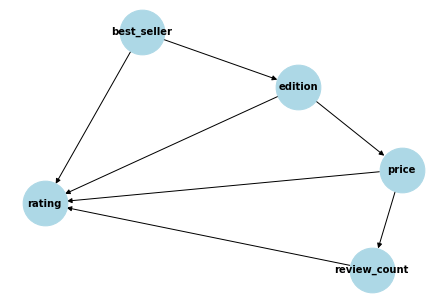

In [4]:
nodes = ['edition', 'best_seller', 'rating', 'review_count', 'price']
edges = [('edition', 'price'),
         ('edition', 'rating'),
         ('price', 'rating'),
         ('best_seller', 'rating'),
         ('best_seller', 'edition'),
         ('review_count','rating'),
         ('price','review_count')]

G_book = nx.DiGraph()


G_book.add_nodes_from(nodes)
G_book.add_edges_from(edges)


pos = nx.spring_layout(G_book)
nx.draw(G_book, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
plt.show()

In [5]:
new_G_book=get_new_G(G_book,bk_df)

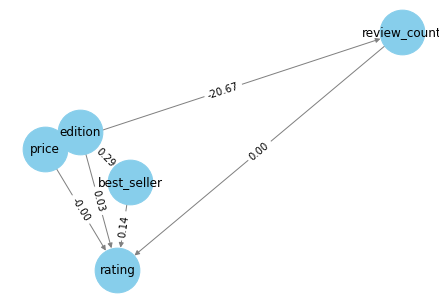

In [6]:
pos = nx.spring_layout(new_G_book)
nx.draw(new_G_book, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G_book.edges(data=True)}
nx.draw_networkx_edge_labels(new_G_book, pos, edge_labels=edge_labels)
plt.show()

### Update price to 5 for edition=1 to rank the rating

In [8]:
bk_df.sort_values(by='rating',ascending=False).head(3)

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
159,C# & C++,5 Books in 1 - The #1 Coding Course from Begin...,Mark Reed,NaN,979-8390090077,2023-04-10,1.0,1.0,No,5.0,320.0,38.82
52,Java,The Ultimate Beginner's Guide to Learn Java Qu...,Mark Reed,NaN,979-8387893131,2023-03-21,1.0,0.0,No,5.0,160.0,24.99
413,Cloud Governance:,Basics and Practice (Professors of Practice) (...,Steven Mezzio,3110755262,978-3110755268,2022-12-05,1.0,NaN,No,5.0,4.0,29.99


In [7]:
top_3_ranking_fix=get_ranking_query(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},opt='fix')
top_3_ranking_fix

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
225,Learning eBPF,Programming the Linux Kernel for Enhanced Obse...,Liz Rice,1098135121,978-1098135126,2023-04-11,1.0,0.0,No,5.249291,995.873069,5.0
451,Certified Ethical Hacker (CEH) v12 312-50 Exam...,Keep up to date with ethical hacking trends an...,Dale Meredith,1801813094,978-1801813099,8-Jul-22,1.0,0.0,No,5.207734,831.526444,5.0
321,Configuring Windows Server Hybrid Advanced Ser...,Configure advanced Windows Server services for...,Chris Gill,1804615099,978-1804615096,2023-04-28,1.0,0.0,No,5.207734,828.526444,5.0


### Baseline
- our baseline is $\frac{1}{^nP_k}$ for all pwd where k is the top k and n is the length of the data.

In [8]:
base_line(bk_df,3)

6.350679706898349e-09

### Simulating ranking probility

In [9]:
top_3_ranking_prob_fix = get_ranking_query_prob(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},opt='fix')
top_3_ranking_prob_fix

,row_index,1,2,3
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,2,0,0.0,0.0
3,3,0,0.0,0.0
4,4,0,0.0,0.0
...,...,...,...,...
536,536,0,0.0,0.0
537,537,0,0.0,0.0
538,538,0,0.0,0.0
539,539,0,0.0,0.0


In [10]:
top_3_ranking_prob_fix_filtered=filter_prob_df(top_3_ranking_prob_fix)
top_3_ranking_prob_fix_filtered

,row_index,1,2,3
225,225,1,0.0,0.0
321,321,0,0.5,0.5
451,451,0,0.5,0.5


In [11]:
calc_prob(top_3_ranking_prob_fix_filtered,6)

[{'ranking_combos': (225, 321, 451), 'probabilities': 0.5},
 {'ranking_combos': (225, 451, 321), 'probabilities': 0.5},
 {'ranking_combos': (321, 225, 451), 'probabilities': 0.0},
 {'ranking_combos': (321, 451, 225), 'probabilities': 0.0},
 {'ranking_combos': (451, 225, 321), 'probabilities': 0.0},
 {'ranking_combos': (451, 321, 225), 'probabilities': 0.0}]

### Stable ranking

In [12]:
stable_rank_fix=get_stable_ranking_opt(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},100,'fix')
stable_rank_fix

[[None, 12.850306503581141], [None, 51]]

#### Verify the ranking by 0.01 std(y) to check having the same ranking

In [13]:
x_sd=np.abs(bk_df['price'].std() * 0.01)

In [44]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':12.850306503581141-x_sd},
                      'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

#### Check the ranking whether will go back to the orginal ranking

In [15]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':5}, 'rating',{'edition':1},
                            stable_rank_fix,1000,0,3,'uper','fix')

[26.088078254717967, 137, 'update upper']
26.088078254717967
Lower Bound Change: (Value: 25.934150676216376, Iteration: 1)
Upper Bound Change: (Value: 33.01481928728954, Iteration: 45)
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

In [113]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':26.088078254717967},
                  'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

In [43]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':33.01481928728954-x_sd},
                  'rating',{'edition':1},opt='fix').index==top_3_ranking_fix.index)

True

#### Group ranking

In [25]:
rank_rating_by_ed=get_ranking_query_prob_grouped(new_G_book, bk_df, 3, {'price':5}, 'rating','edition',{'edition':1},'fix')
rank_rating_by_ed_filtered=filter_prob_df_grouped(rank_rating_by_ed)
rank_rating_by_ed_filtered

,group_col,1,2,3
5,6.0,1,0.0,0.0
7,8.0,0,0.5,0.5
8,10.0,0,0.5,0.5


In [26]:
calc_prob(rank_rating_by_ed_filtered,6)

[{'ranking_combos': (5, 7, 8), 'probabilities': 0.5},
 {'ranking_combos': (5, 8, 7), 'probabilities': 0.5},
 {'ranking_combos': (7, 5, 8), 'probabilities': 0.0},
 {'ranking_combos': (7, 8, 5), 'probabilities': 0.0},
 {'ranking_combos': (8, 5, 7), 'probabilities': 0.0},
 {'ranking_combos': (8, 7, 5), 'probabilities': 0.0}]

### Update price by 2 times for edition=1 to rank the rating

In [67]:
top_3_ranking_multi=get_ranking_query(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},opt='multiply_by')
top_3_ranking_multi

,title,description,author,isbn10,isbn13,publish_date,edition,best_seller,top_rated,rating,review_count,price
35,Rust Web Programming,"A hands-on guide to developing, packaging, and...",Maxwell Flitton,1803234695,978-1803234694,2023-01-27,2.0,1.0,No,5.0,4.0,44.99
125,Rust Web Programming,"A hands-on guide to developing, packaging, and...",Maxwell Flitton,1803234695,978-1803234694,2023-01-27,2.0,0.0,No,5.0,5.0,44.99
189,SQL,The #1 Crash Course for Beginners to Master SQ...,James Howard,NaN,979-8394081941,2023-05-10,NaN,0.0,No,5.0,133.0,19.99


### Simulating ranking probility

In [73]:
top_3_ranking_prob_multi = get_ranking_query_prob(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},opt='multiply_by')
top_3_ranking_prob_multi

,row_index,1,2,3
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
...,...,...,...,...
536,536,0.0,0.0,0.0
537,537,0.0,0.0,0.0
538,538,0.0,0.0,0.0
539,539,0.0,0.0,0.0


In [74]:
top_3_ranking_prob_multi_filtered=filter_prob_df(top_3_ranking_prob_multi)
top_3_ranking_prob_multi_filtered

,row_index,1,2,3
35,35,0.166667,0.166667,0.166667
125,125,0.166667,0.166667,0.166667
189,189,0.166667,0.166667,0.166667
294,294,0.166667,0.166667,0.166667
310,310,0.166667,0.166667,0.166667
312,312,0.166667,0.166667,0.166667


In [75]:
probs_multi=calc_prob(top_3_ranking_prob_multi_filtered,120)

probs_multi[1:10]

[{'ranking_combos': (35, 125, 294), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 125, 310), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 125, 312), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 125), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 294), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 310), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 189, 312), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 294, 125), 'probabilities': 0.008333333333333318},
 {'ranking_combos': (35, 294, 189), 'probabilities': 0.008333333333333318}]

### Stable ranking

In [76]:
stable_rank_multi=get_stable_ranking_opt(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},100,'multiply_by')
stable_rank_multi

Lower Bound Change: (Value: 1.7332110240376257, Iteration: 1)
Upper Bound Change: (Value: 2.66309771285309, Iteration: 2)


[[1.7332110240376257, 2.66309771285309], [1, 2]]

#### Verify the ranking by 0.01 std(y) to check having the same ranking

In [127]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':1.7332110240376257*(1+x_sd)}, 'rating',{'edition':1},
                           opt='multiply_by').index==top_3_ranking_multi.index)


True

In [99]:
all(get_ranking_query(new_G_book, bk_df, 3, {'price':2.66309771285309/(1+x_sd)}, 'rating',{'edition':1},
                           opt='multiply_by').index==top_3_ranking_multi.index)

True

#### Check the ranking whether will go back to the orginal ranking

In [146]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},
                            stable_rank_multi,1000,0,3,'uper','multiply_by')

no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

In [145]:
get_test_revert_ranking_rec(new_G_book, bk_df, 3, {'price':2}, 'rating',{'edition':1},
                            stable_rank_multi,1000,0,3,'lower','multiply_by')

no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000
no updtaes,increase the max iteration by 1000


'the iteration ends'

#### Group ranking

In [147]:
rank_rating_by_ed=get_ranking_query_prob_grouped(new_G_book, bk_df, 3, {'price':2}, 'rating','edition',{'edition':1},'multiply_by')
rank_rating_by_ed_filtered=filter_prob_df_grouped(rank_rating_by_ed)
rank_rating_by_ed_filtered

,group_col,1,2,3
5,6.0,1,0.0,0.0
7,8.0,0,0.5,0.5
8,10.0,0,0.5,0.5


In [148]:
calc_prob(rank_rating_by_ed_filtered,6)

[{'ranking_combos': (5, 7, 8), 'probabilities': 0.5},
 {'ranking_combos': (5, 8, 7), 'probabilities': 0.5},
 {'ranking_combos': (7, 5, 8), 'probabilities': 0.0},
 {'ranking_combos': (7, 8, 5), 'probabilities': 0.0},
 {'ranking_combos': (8, 5, 7), 'probabilities': 0.0},
 {'ranking_combos': (8, 7, 5), 'probabilities': 0.0}]